## Predicting Pectin extraction yield from FTIR ($X_1$) and Carbohydrate Microarray ($X_2$) data

In this example we use Multiblock Partial Least Squares regression to predict the pectin extraction yield for samples which were measured on FTIR and Carbohydrate Microarrays. The aim is not only to establish prediction models, but also to investigate how much each block contributes to the prediction of the extraction yield. We recommend that you check out the FTIR and Carbohydrate Microarray notebooks prior to working on this notebook. These two notebooks elaborate on modeling pectin yield using both data sets independently.

## Load dependencies and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

# X1 part
ftir1 = pd.read_pickle('ftir1.pkl')
ftir2 = pd.read_pickle('ftir2.pkl')
ftir3 = pd.read_pickle('ftir3.pkl')
# X2 part
carb1 = pd.read_pickle('extraction1.pkl')
carb2 = pd.read_pickle('extraction2.pkl')
carb3 = pd.read_pickle('extraction3.pkl')

## Merge all dataframes across the sample dimension
To get started with our MBPLS modeling we merge all dataframes across the sample dimension, meaning that extractions 1, 2 and 3 are merged for FTIR ($X_1$), Carbohydrate Microarray ($X_2$) and pectin yield ($Y$) data.

In [2]:
x1 = pd.concat((ftir1, ftir2, ftir3))
x2 = pd.concat((carb1, carb2, carb3))
x2.index = x1.index
y = np.array(x2.index)
wavenumbers = x1.columns
x1x2 = pd.concat((x1, x2), axis=1)

## Find number of latent variables using leave-one-out Cross Validation
To find the right number of latent variables (LV) we perform cross validation. Scikit learn makes it easy for us using the cross_val_predict function. We simply re-model the data using different numbers of latent variables and plot the result of the resulting Mean Square Errors (MSE). We pick the number of latent variables where the MSE is minimal to avoid overfitting and to induce as much complexity into our model as to obtained best possible results.

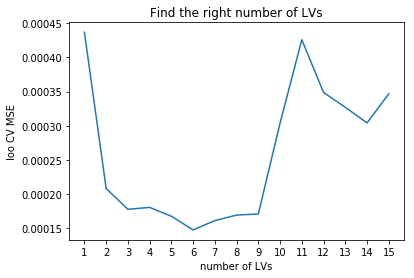

In [3]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

MSEs = []
for lv in range(15):
    mbpls = MBPLS(n_components=lv+1)
    prediction = cross_val_predict(mbpls, x1x2, y, cv=len(x1x2))
    prediction = pd.DataFrame(prediction)
    MSEs.append(mean_squared_error(prediction, y))

plt.plot(np.arange(1,16), MSEs)
plt.xlabel('number of LVs')
plt.xticks(np.arange(1,16), np.arange(1,16))
plt.ylabel('loo CV MSE')
plt.title('Find the right number of LVs');

## Plot resulting calibration curve and evaluate model 
Our plot above indicates that 3 LVs are necessary to establish our MBPLS model. We choose 3 instead of 6 LVs to avoid from overfitting due to the small sample size. We re-model using 3 LVs and plot the resulting calibration to evaluate the mean square prediction error (MSE) of cross validation. 

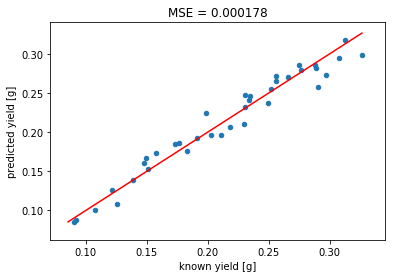

In [4]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

mbpls = MBPLS(n_components=3)
prediction = cross_val_predict(mbpls, x1x2, y, cv=len(x1x2))
prediction = pd.DataFrame(prediction)
y = pd.DataFrame(y)
prediction = pd.concat((prediction, y), axis=1)
prediction.columns=['predicted yield [g]', 'known yield [g]']
prediction.plot.scatter(x='known yield [g]', y='predicted yield [g]')
plt.plot([prediction.min().min(), prediction.max().max()], [prediction.min().min(), prediction.max().max()], color='red')
plt.title('MSE = %.6f' % mean_squared_error(prediction['known yield [g]'], prediction['predicted yield [g]']));

## Interpret Multiblock PLS model
Up to now we have done nothing different than prediction modeling. Although we have used MBPLS the solution is equivalent to PLS because the feature blocks $X_1$ and $X_2$ were simply concatenated and super score deflation was applied as previously described in [ref].

Now we want to find out more about how each individual feature block contributes to the actual prediction of pectin yield. To do so we fit an MBPLS estimator as it is done using the Scikit Learn framework and look at the results using the built-in *plot* method

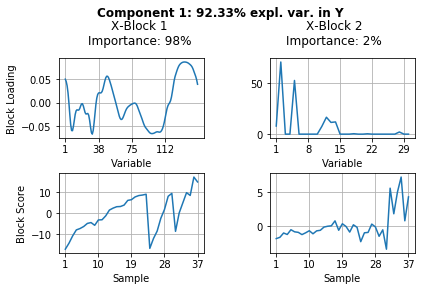

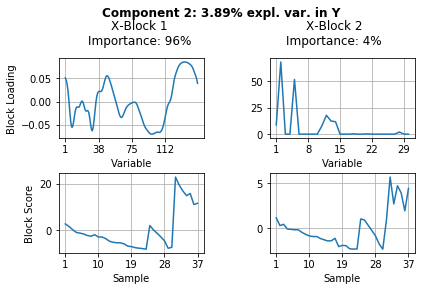

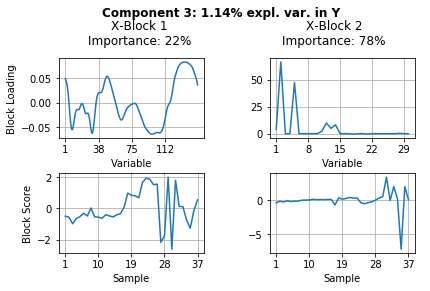

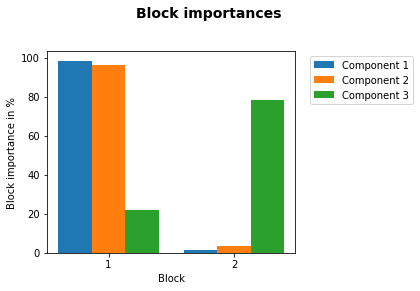

In [5]:
mbpls = MBPLS(n_components=3, method='UNIPALS')
mbpls.fit(X=[x1, x2], Y=y)
# Plot results for the first num_components (LVs)
mbpls.plot(num_components=3)

**The results above show a lot of information. Let's summarize what we can see from these results.**

1. Component 1 (= LV1) explains 92.3% of variance in pectin yield ($Y$).
2. For the explanation of these 92.3% Block $X_1$ is of 98% and Block $X_2$ of 2% importance.
3. Because Block $X_1$ is of major importance to explain most of the variance in pectin yield we can go ahead and look further at the Block Loadings and Scores for this component. We merged our data in the sequence extraction 1 (samples 1-23), extraction 2 (samples 24-30) and extraction 3 (samples 31-37). It turns out that the latent variable loading of component one indicates the FTIR spectral regions which explain differences in pectin yield at different time points during extraction.
4. Component 2 explains 3.9% variance in pectin yield. Once again the FTIR block $X_1$ is of most importance. Looking at the Block Scores here we can see that it differentiates between enzymatic extractions 1 and 2 and acid extaction 3. The FTIR Block Loadings looks quite similar although some subtle differences exist due to different chemical matrices during extraction (see below).
5. Component 3 explains only 1.1% of variance in pectin yield. In this component the carbohydrate microarray data block contained more important information (78% importance). Looking at the Block Scores one can find out which samples are highly affected by this component - mainly sample 35 and other samples of the acidic extraction 3. The Block Loading helps to indentify which of the 30 monoclonal antibodies and/or Carbohydrate Binding modules were responsible for these samples to vary from the rest. 
6. We can conclude that FTIR data is of most importance for prediction of pectin yield. However, the data from the carbohydrate microarrays contribute to the prediction model slightly and can explain minor differences between the different samples. However, these results should be handled carfeully because of the small data size and, hence, insufficient validation of the prediction models.

## Let's look at (Block) Score Plots to identify extraction patterns (enzymatic versus acid)
### FTIR Block ($X_1$)
As discussed above we can identify certain patterns

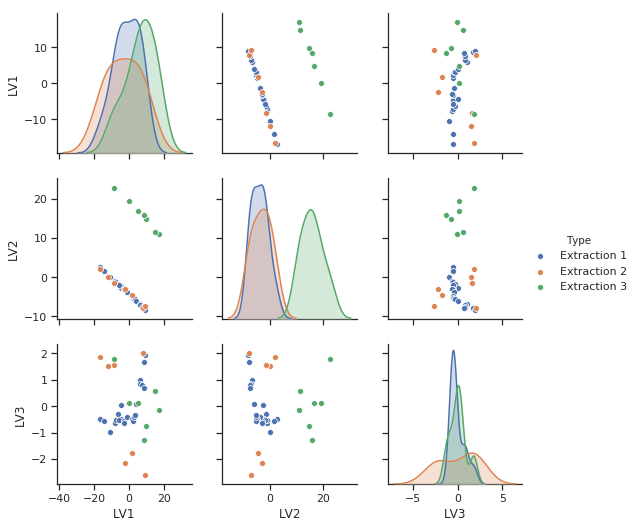

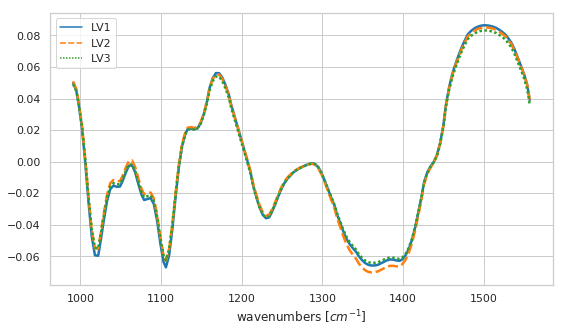

In [12]:
block_scores_x1 = mbpls.T_[0]
block_loadings_x1 = mbpls.P_block_[0].T
block_loadings_x1 = np.hstack([mbpls.x_scalers_[0].inverse_transform(loading).reshape(-1, 1) 
                               for loading in block_loadings_x1])

import itertools
colors = [['Extraction 1']*23, ['Extraction 2']*7, ['Extraction 3']*7]
colors = list(itertools.chain(*colors))
colors = pd.DataFrame(colors, columns=['Type'])

block_scores_x1 = pd.DataFrame(block_scores_x1, columns=['LV1', 'LV2', 'LV3'])
block_scores_x1 = pd.concat((block_scores_x1, colors), axis=1)
block_loadings_x1 = pd.DataFrame(block_loadings_x1, columns=['LV1', 'LV2', 'LV3'], index=wavenumbers)

import seaborn as sns
sns.set(style="ticks")
sns.pairplot(block_scores_x1, hue="Type")
plt.figure(figsize=(9,5))
sns.set(style="whitegrid")
sns.lineplot(data=block_loadings_x1, palette="tab10", linewidth=2.5)
plt.xlabel('wavenumbers [$cm^{-1}$]');

## Let's look at (Block) Score Plots to identify extraction patterns (enzymatic versus acid)
### Carbohydrate Microarray Block ($X_2$)

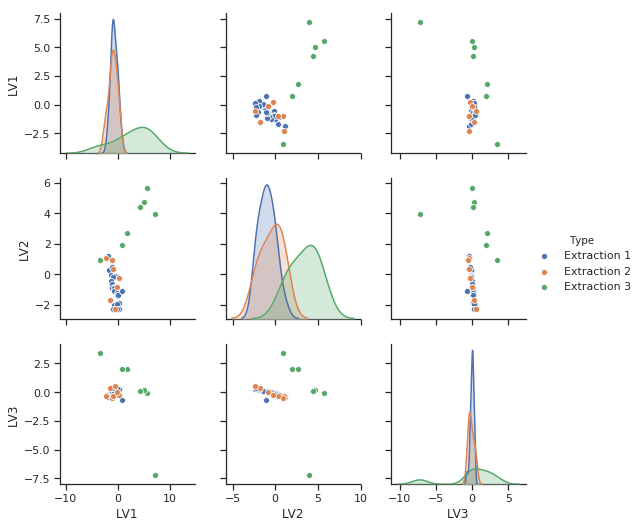

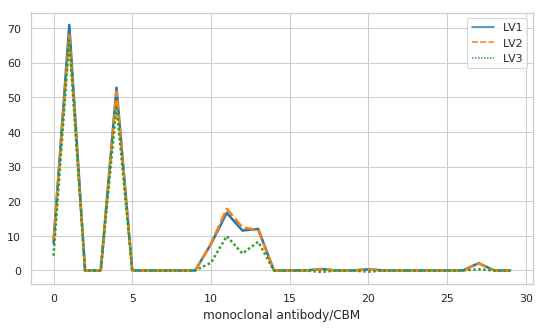

In [7]:
block_scores_x2 = mbpls.T_[1]
block_loadings_x2 = mbpls.P_block_[1].T
block_loadings_x2 = np.hstack([mbpls.x_scalers_[1].inverse_transform(loading).reshape(-1, 1) 
                               for loading in block_loadings_x2])

import itertools
colors = [['Extraction 1']*23, ['Extraction 2']*7, ['Extraction 3']*7]
colors = list(itertools.chain(*colors))
colors = pd.DataFrame(colors, columns=['Type'])

block_scores_x2 = pd.DataFrame(block_scores_x2, columns=['LV1', 'LV2', 'LV3'])
block_scores_x2 = pd.concat((block_scores_x2, colors), axis=1)
block_loadings_x2 = pd.DataFrame(block_loadings_x2, columns=['LV1', 'LV2', 'LV3'])

import seaborn as sns
sns.set(style="ticks")
sns.pairplot(block_scores_x2, hue="Type")
plt.figure(figsize=(9,5))
sns.set(style="whitegrid")
sns.lineplot(data=block_loadings_x2, palette="tab10", linewidth=2.5)
plt.xlabel('monoclonal antibody/CBM');

## Correct Block importance for different number of features (variables) in the blocks $X_1$ and $X_2$

The Block importance measure depends on the number of features in each block. The FTIR data ($X_1$) contained 143 features, while the carbohydrate microarray data ($X_2$) contained only 30 features. In such cases it might be desriable to correct the Block importance for such differences. With our MBPLS package we have built in a corrected measure which yields the corrected block importance for component $k$ and block $i$ such that: 

$BIP_{corr,ik} = BIP_{ik} \cdot (1- \frac{p_i}{p_{total}})$

In the table below BIPs and block size corrected BIPs are presented for our example.

In [8]:
print('The Block Importances in each latent variable are:')
BIP = pd.DataFrame(mbpls.A_.round(2), columns=['LV1', 'LV2', 'LV3'], index=['FTIR', 'Carb Micr Array'])
BIP

The Block Importances in each latent variable are:


,LV1,LV2,LV3
FTIR,0.98,0.96,0.22
Carb Micr Array,0.02,0.04,0.78


In [9]:
print('The corrected Block Importances in each latent variable are:')
BIP_corrected = pd.DataFrame(mbpls.A_corrected_.round(2), columns=['LV1', 'LV2', 'LV3'], index=['FTIR', 'Carb Micr Array'])
BIP_corrected

The corrected Block Importances in each latent variable are:


,LV1,LV2,LV3
FTIR,0.93,0.85,0.05
Carb Micr Array,0.07,0.15,0.95


In [10]:
mbpls.P_block_[1].shape

(30, 3)